In [1]:
from cellpose import models, plot, io, utils
import matplotlib.pyplot as plt
from tifffile import imread
import numpy as np
from scipy.ndimage import center_of_mass
import os


In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 175
mpl.rcParams['figure.figsize']=4,4
dpi=800

'''Plot the outlines of masks'''
def plot_outlines(mask, image, title, directory):
    outlines = utils.outlines_list(mask)
    # Combine the RGB channels
    plot_img=np.zeros((image.shape[1], image.shape[2], 3))
    plot_img[:,:,0]=image[0]/np.max(image[0])
    plot_img[:,:,1]=image[1]/np.max(image[1])
    plot_img[:,:,2]=image[2]/np.max(image[2])
    plt.imshow(plot_img)
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color='pink', alpha=0.5)
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"{directory}/{title}.png", dpi=dpi)
    plt.show()
    plt.close()

def plot_both_outlines(mask1, mask2, image, title, directory):
    # Combine the RGB channels
    plot_img=np.zeros((image.shape[1], image.shape[2], 3))
    plot_img[:,:,0]=image[0]/np.max(image[0])
    plot_img[:,:,1]=image[1]/np.max(image[1])
    plot_img[:,:,2]=image[2]/np.max(image[2])
    plt.imshow(plot_img)
    outlines = utils.outlines_list(mask1)
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color='pink', alpha=0.5)
    outlines = utils.outlines_list(mask2)
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color='red', alpha=0.5)
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"{directory}/{title}.png", dpi=dpi)
    plt.show()
    plt.close()

'''Function for the identification of neurons'''
def microscopy_analysis(source,                 # Path to the original tiff file
                        cell_parameters,        # Tuple containing parameters for the cell model (dia, flow, cellprob)
                        nucleus_parameters      # Tuple containing parameters for the nucleus model (dia, flow, cellprob)
                        ):
    
    # Create an output folder for the figures
    directory=os.path.splitext(source)[0]
    if not os.path.isdir(directory):
        os.mkdir(directory)

    print(directory)

    '''Analyse the source file using the cyto3 and nuclei model'''
    # The file can be read using tifffile imread
    img = imread(source)

    # Plot the original image
    # Combine the RGB channels
    plot_img=np.zeros((img.shape[1], img.shape[2], 3))
    plot_img[:,:,0]=img[0]/np.max(img[0])
    plot_img[:,:,1]=img[1]/np.max(img[1])
    plot_img[:,:,2]=img[2]/np.max(img[2])
    plt.imshow(plot_img)
    plt.axis('off')
    plt.title("Original Image")
    plt.savefig(f"{directory}/original_image.png", dpi=dpi)
    plt.show()
    plt.close()
    
    # Define the model, if you own an nvidia gpu, the 'gpu' setting can be set to 'True' to accelerate the analysis
    model = models.Cellpose(gpu=True, model_type='cyto3')

    # For the cell bodies, the first channel should be the marker for the cell bodies,
    # the second channel (optional) is for the nuclei marker
    channel = [1,3]

    # Run the model with the cell body parameters
    cellmasks, flows, styles, diams = model.eval(img, diameter=cell_parameters[0], channels=channel, flow_threshold=cell_parameters[1], cellprob_threshold=cell_parameters[2])

    # Display the preliminary results
    plot_outlines(mask=cellmasks, image=img, title="Preliminary cell body identification", directory=directory)

    # Redefine the model using the nuclei model
    model = models.Cellpose(gpu=True, model_type='cyto3')

    # The first channel is the nuclei channel, the second channel should be set to 0 (none)
    channel = [3,0]

    # Run the model with the nuclei parameters
    nucleimasks, flows, styles, diams = model.eval(img, diameter=nucleus_parameters[0], channels=channel, flow_threshold=nucleus_parameters[1], cellprob_threshold=nucleus_parameters[2])

    # Display the preliminary results
    plot_outlines(mask=nucleimasks, image=img, title="Preliminary nuclei identification", directory=directory)

    plot_both_outlines(cellmasks, nucleimasks, img, 'Combined preliminary outlines', directory)

    '''Validate the cell bodies and nuclei'''
    cellbodies=np.max(cellmasks)
    nuclei=np.max(nucleimasks)
    print(f"{cellbodies} cell bodies found")
    print(f"{nuclei} nuclei found")

    '''Identify neurons that do not contain at least 50% of a nucleus'''
    nuclei_mask_with_neuron_id=np.zeros((img[0].shape[0], img[0].shape[1]))
    # Loop over all cell bodies
    false_cell_bodies=[]
    overlap_list_list=[]
    couple_list=[]
    for cell_body in range(1,cellbodies+1):
        overlap_list=[]
        # Create a temporary mask for the cell body
        cell_body_mask=cellmasks==cell_body
        # Loop over all nuclei
        for nucleus in range(1,nuclei+1):
            # Create a temprorary mask for the nuclei
            nucleus_mask=nucleimasks==nucleus
            # Calculate the size of the nucleus
            nucleus_size=np.sum(nucleus_mask)
            # Calculate the % overlap with the cell body
            combinedmask=np.logical_and(cell_body_mask, nucleus_mask)
            overlap=np.sum(combinedmask)/nucleus_size
            overlap_list.append(overlap)
        # print(overlap_list)
        overlap_list_list.append(overlap_list)
        if not np.max(overlap_list)>0.5:
            # print("Cell body without nucleus detected")
            false_cell_bodies.append(cell_body)
        else:
            # Assign all nuclei with >50% overlap to the cell body
            # 'multiple nuclei', because sometimes the algorithm will identify 1 nuclei as multiple
            # At the same time, this will remove any nuclei that do not have sufficient overlap with a cell body
            nucleus_indexes = [i for i, value in enumerate(overlap_list) if value > 0.5]
            for i in nucleus_indexes:
                temp_mask=nucleimasks==i+1
                nuclei_mask_with_neuron_id[temp_mask]=cell_body
                # Remember which nuclei is coupled with which
                couple_list.append([cell_body, i])
    print(f"{len(false_cell_bodies)} cell bodies detected without a nucleus")

    '''Merge or remove false cell bodies'''
    merged_bodies=0
    deleted_bodies=0
    for index in false_cell_bodies:
        # First, check if we can merge the false cell body with another cell body they share a nucleus with
        # Retrieve the overlapp list
        overlap_list=overlap_list_list[index-1]
        max_overlap=np.argmax(overlap_list)

        # Check if it had any overlap with a nucleus that is already coupled to a neuron
        if not np.max(overlap_list)==0:
            could_merge=False
            # Look up which cell body is linked tot his nucleus
            for item in couple_list:
                if item[1]==max_overlap:
                    # Merge the cell bodies
                    cellmasks[cellmasks==index]=item[0]
                    could_merge=True
            # If we could not merge, also remove the false cell body
            if not could_merge:
                # Remove false cell bodies
                mask=cellmasks==index
                cellmasks[mask]=0
                deleted_bodies+=1
            else: 
                merged_bodies+=1
                
        else:
            # Remove false cell bodies
            mask=cellmasks==index
            cellmasks[mask]=0
            deleted_bodies+=1
        
        
    print(f"{merged_bodies} cells merged, {deleted_bodies} cells removed")


    '''Allign cell bodies and nuclei'''
    # It might be possible that not all of the pixels of a nucleus, are entirely within the linked cell body
    # This is fixed by making sure all pixels of the nucleus are also correctly labeled on the cellmask
    # Loop over all nuclei
    for nucleus in np.unique(nuclei_mask_with_neuron_id[nuclei_mask_with_neuron_id != 0]):
        temp_mask=nuclei_mask_with_neuron_id==nucleus
        cellmasks[temp_mask]=nucleus

    '''Display the validation results'''
    nuclei_mask_with_neuron_id=nuclei_mask_with_neuron_id.astype(int)
    cmap='twilight'
    cmap2='hot'
    ALPHA=0.75

    colour_values=np.random.rand(np.max(cellmasks)+1)

    print(f"{len(np.unique(cellmasks))-1} cell bodies validated")
    print(f"{len(np.unique(nuclei_mask_with_neuron_id))-1} nuclei validated")

    plot_cellmasks=np.zeros(cellmasks.shape)
    for value in np.unique(cellmasks):
        if value !=0:
            plot_cellmasks[cellmasks==value]=colour_values[value]
    plt.imshow(img[0], cmap=cmap2)
    plt.imshow(plot_cellmasks, cmap=cmap, alpha=((cellmasks!=0).astype(float))*ALPHA)
    for cell_body in np.unique(cellmasks[cellmasks != 0]):
        center=center_of_mass(cellmasks==cell_body)
        plt.text(center[1], center[0], str(cell_body), color='white', ha='center', va='center', fontsize=12)
    plt.axis('off')
    plt.savefig(f"{directory}/validated_cell_masks.png", dpi=dpi)
    plt.show()
    plt.close()

    plot_nuclei=np.zeros(nuclei_mask_with_neuron_id.shape)
    for value in np.unique(nuclei_mask_with_neuron_id):
        if value !=0:
            plot_nuclei[nuclei_mask_with_neuron_id==value]=colour_values[value]
    plt.imshow(img[0], cmap=cmap2)
    plt.imshow(plot_nuclei, cmap=cmap, alpha=((nuclei_mask_with_neuron_id!=0).astype(float))*ALPHA)
    for nucleus in np.unique(nuclei_mask_with_neuron_id[nuclei_mask_with_neuron_id != 0]):
        center=center_of_mass(nuclei_mask_with_neuron_id==nucleus)
        plt.text(center[1], center[0], str(nucleus), color='white', ha='center', va='center', fontsize=12)
    plt.axis('off')
    plt.savefig(f"{directory}/validated_nuclei_masks.png", dpi=dpi)
    plt.show()
    plt.close()

    # print(np.unique(cellmasks))
    # print(np.unique(nuclei_mask_with_neuron_id))

    plot_outlines(cellmasks, img, 'Validated cell body identification', directory=directory)
    plot_outlines(nuclei_mask_with_neuron_id, img, 'Validated nuclei identification', directory=directory)

    plot_both_outlines(cellmasks, nuclei_mask_with_neuron_id, img, 'Combined validated outlines', directory)

# filename='G:/Microscopy_Data_Huntingtin_aggregates/test/stacked_4_channels.tif'
# cell_parameters=(250, 0.6, -2)
# nucleus_parameters=(300, 1, -2)
# microscopy_analysis(filename, cell_parameters, nucleus_parameters)

In [3]:
#good
'''zstacked_sum_20240131_CKR_E10B_mHtt-HAQ25Doxy96H_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_3
zstacked_sum_20240131_CKR_E10B_mHtt-HAQ46Doxy72h_MG132-4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488
zstacked_sum_20240131_CKR_E10B_mHtt-HAQ46Doxy72h_MG132-4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_2
zstacked_sum_20240131_CKR_E10B_mHtt-HAQ97Doxy72H_BafA4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_2
zstacked_sum_20240131_CKR_E10B_mHtt-HAQ97Doxy72H_BafA4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_3
zstacked_sum_20240131_CKR_E10B_mHtt-HAQ97Doxy96h_MG132-4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488
zstacked_sum_20240131_CKR_E10B_mHtt-HAQ97Doxy96h_MG132-4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_6
zstacked_sum_20240212_CKR_E10B_mHtt-HAQ46doxy24h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_2'''


'zstacked_sum_20240131_CKR_E10B_mHtt-HAQ25Doxy96H_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_3\nzstacked_sum_20240131_CKR_E10B_mHtt-HAQ46Doxy72h_MG132-4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488\nzstacked_sum_20240131_CKR_E10B_mHtt-HAQ46Doxy72h_MG132-4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_2\nzstacked_sum_20240131_CKR_E10B_mHtt-HAQ97Doxy72H_BafA4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_2\nzstacked_sum_20240131_CKR_E10B_mHtt-HAQ97Doxy72H_BafA4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_3\nzstacked_sum_20240131_CKR_E10B_mHtt-HAQ97Doxy96h_MG132-4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488\nzstacked_sum_20240131_CKR_E10B_mHtt-HAQ97Doxy96h_MG132-4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_6\nzstacked_sum_20240212_CKR_E10B_mHtt-HAQ46doxy24h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_2'

In [4]:
# cell_parameters=(250, 0.6, -2)
# nucleus_parameters=(300, 1, -2)
# microscopy_analysis("G:/Microscopy_Data_Huntingtin_aggregates/stacked_tiff/zstacked_sum_20240212_CKR_E10B_mHtt-HAQ46doxy24h_BafA1_HA-STAR580_CCCT1-STAR635P_A11-STAR460L_nucspotlive488_2.tif", cell_parameters, nucleus_parameters)

In [5]:
import os
import glob

cell_parameters=(250, 0.6, -2)
nucleus_parameters=(150, 0.4, 2)

# Specify the directory and file extension
directory = "G:/Microscopy_Data_Huntingtin_aggregates/stacked_tiff"
extension = "*.tif"  # change to your desired file extension

# Get a list of files with the specific extension
file_list = glob.glob(os.path.join(directory, extension))

# Print the list of files
for file in file_list:
    try:
        print(file)
        microscopy_analysis(file, cell_parameters, nucleus_parameters)
    except Exception as error:
        print(f"Could not process {file}\n{error}")

In [1]:
from cellpose import models, plot, io, utils
import matplotlib.pyplot as plt
from tifffile import imread
import numpy as np
from scipy.ndimage import center_of_mass
import os
import warnings
import cv2
warnings.filterwarnings("ignore")

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 175
mpl.rcParams['figure.figsize']=4,4
dpi=800

'''Plot the outlines of masks'''
def own_outlines(masks):
    outpix = []
    for n in np.unique(masks)[1:]:
        mn = masks == n
        if mn.sum() > 0:
            contours = cv2.findContours(mn.astype(np.uint8), mode=cv2.RETR_EXTERNAL,
                                        method=cv2.CHAIN_APPROX_NONE)
            contours = contours[-2]
            
            for contour in contours:
                pix = contour.astype(int).squeeze()
                if len(pix) > 4:
                    outpix.append(pix)
                else:
                    outpix.append(np.zeros((0, 2)))
    
    return outpix

def plot_outlines(mask, image, title, directory):
    # outlines = utils.outlines_list(mask)
    outlines = own_outlines(mask)
    # Combine channels into RGB image
    plot_img=np.zeros((image.shape[1], image.shape[2], 3))
    plot_img[:,:,0]=image[0]/np.max(image[0])
    plot_img[:,:,1]=image[1]/np.max(image[1])
    plot_img[:,:,2]=image[2]/np.max(image[2])
    plt.imshow(plot_img)
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color='pink', alpha=0.5)
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"{directory}/{title}.png", dpi=dpi)
    plt.show()
    plt.close()

def plot_both_outlines(mask1, mask2, image, title, directory):
    # Combine the RGB channels
    plot_img=np.zeros((image.shape[1], image.shape[2], 3))
    plot_img[:,:,0]=image[0]/np.max(image[0])
    plot_img[:,:,1]=image[1]/np.max(image[1])
    plot_img[:,:,2]=image[2]/np.max(image[2])
    plt.imshow(plot_img)
    outlines = own_outlines(mask1)
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color='pink', alpha=0.5)
    outlines = own_outlines(mask2)
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color='red', alpha=0.5)
    plt.axis('off')
    plt.title(title)
    plt.savefig(f"{directory}/{title}.png", dpi=dpi)
    plt.show()
    plt.close()

/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Microscopy Data Huntingtin aggregates/Raw data #1/20240131_CKR_E10B_mHtt-HAQ25Doxy96H_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_1_MAX_Composite


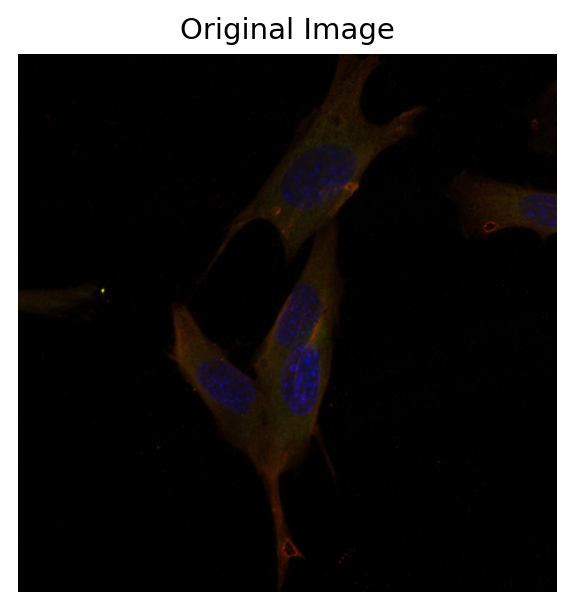

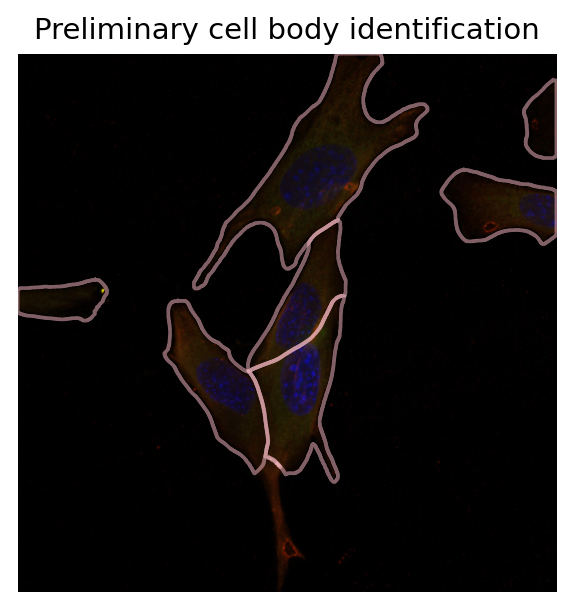

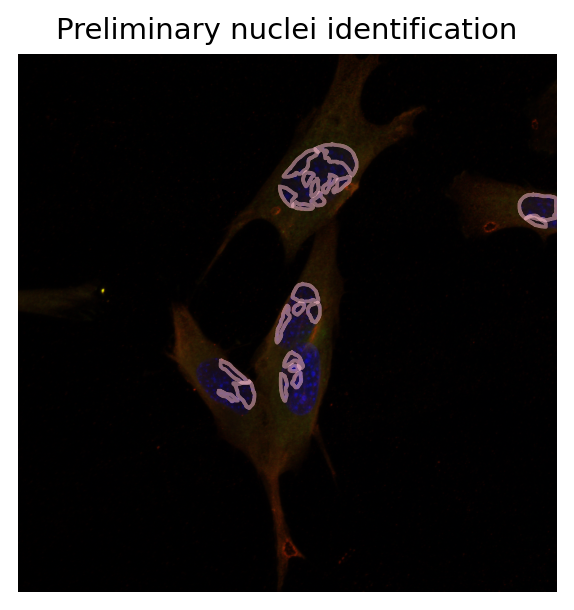

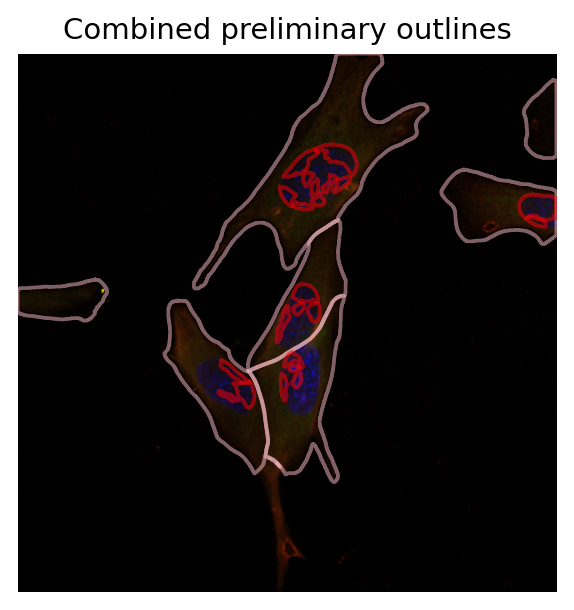

In [9]:
'''Function for the identification of neurons'''
source='/Users/noahwijnheijmer/Library/CloudStorage/OneDrive-HvA/afstuderen/Microscopy Data Huntingtin aggregates/Raw data #1/20240131_CKR_E10B_mHtt-HAQ25Doxy96H_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_1_MAX_Composite.tif'                 # Path to the original tiff file
cell_parameters=(250, 0.6, -2)          # Tuple containing parameters for the cell model (dia, flow, cellprob)
nucleus_parameters=(75, 0.4, 2)         # Tuple containing parameters for the nucleus model (dia, flow, cellprob)

# Create an output folder for the figures
directory=os.path.splitext(source)[0]
print(directory)
if not os.path.isdir(directory):
    os.mkdir(directory)


'''Analyse the source file using the cyto3 model'''
# The file can be read using tifffile imread
img = imread(source)

# Plot the original image
# Combine the RGB channels
plot_img=np.zeros((img.shape[1], img.shape[2], 3))
plot_img[:,:,0]=img[0]/np.max(img[0])
plot_img[:,:,1]=img[1]/np.max(img[1])
plot_img[:,:,2]=img[2]/np.max(img[2])
plt.imshow(plot_img)
plt.axis('off')
plt.title("Original Image")
plt.savefig(f"{directory}/original_image.png", dpi=dpi)
plt.show()
plt.close()

# Define the model, if you own an nvidia gpu, the 'gpu' setting can be set to 'True' to accelerate the analysis
model = models.Cellpose(gpu=False, model_type='cyto3')

# For the cell bodies, the first channel should be the marker for the cell bodies,
# the second channel (optional) is for the nuclei marker
channel = [1,3]

# Run the model with the cell body parameters
cellmasks, flows, styles, diams = model.eval(img, diameter=cell_parameters[0], channels=channel, flow_threshold=cell_parameters[1], cellprob_threshold=cell_parameters[2])

# Display the preliminary results
plot_outlines(mask=cellmasks, image=img, title="Preliminary cell body identification", directory=directory)

# Redefine the model using the nuclei model
model = models.Cellpose(gpu=False, model_type='cyto3')

# The first channel is the nuclei channel, the second channel should be set to 0 (none)
channel = [3,0]

# Run the model with the nuclei parameters
nucleimasks, flows, styles, diams = model.eval(img, diameter=nucleus_parameters[0], channels=channel, flow_threshold=nucleus_parameters[1], cellprob_threshold=nucleus_parameters[2])

# Display the preliminary results
plot_outlines(mask=nucleimasks, image=img, title="Preliminary nuclei identification", directory=directory)

plot_both_outlines(cellmasks, nucleimasks, img, 'Combined preliminary outlines', directory)

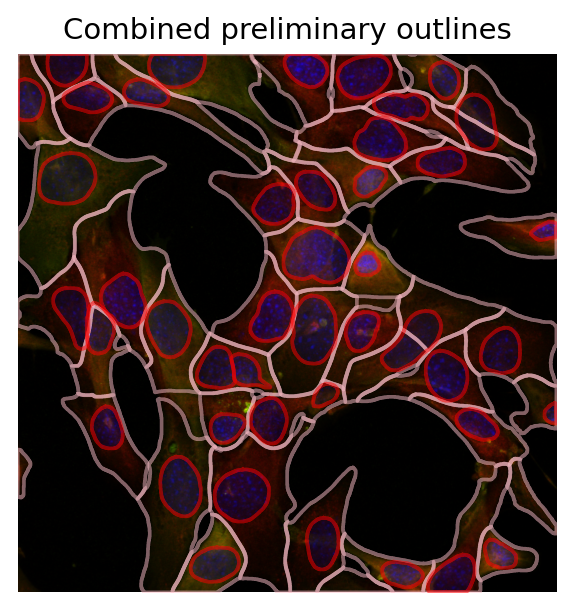

In [ ]:
plot_both_outlines(cellmasks, nucleimasks, img, 'Combined preliminary outlines', directory)

48 cell bodies found
44 nuclei found
6 cell bodies detected without a nucleus
0 cell bodies merged, 6 cell bodies removed
42 cell bodies validated
42 nuclei validated


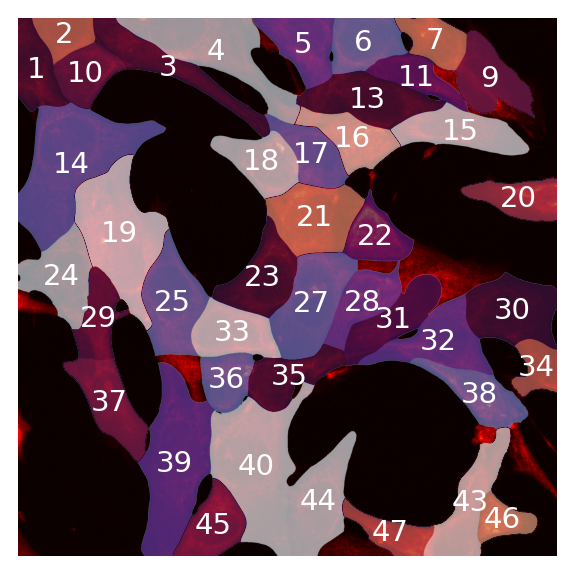

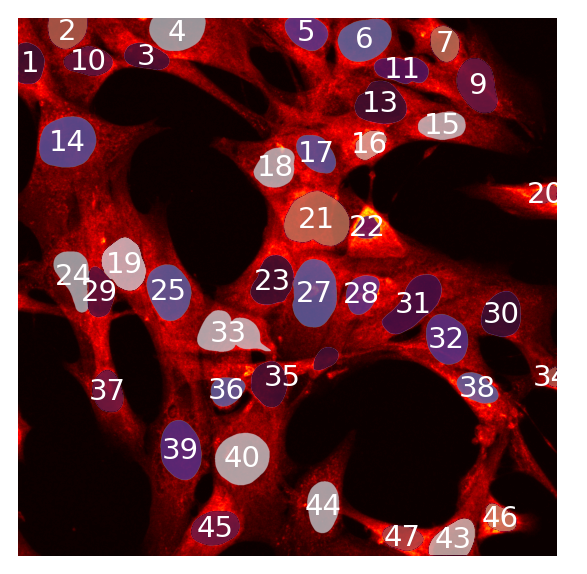

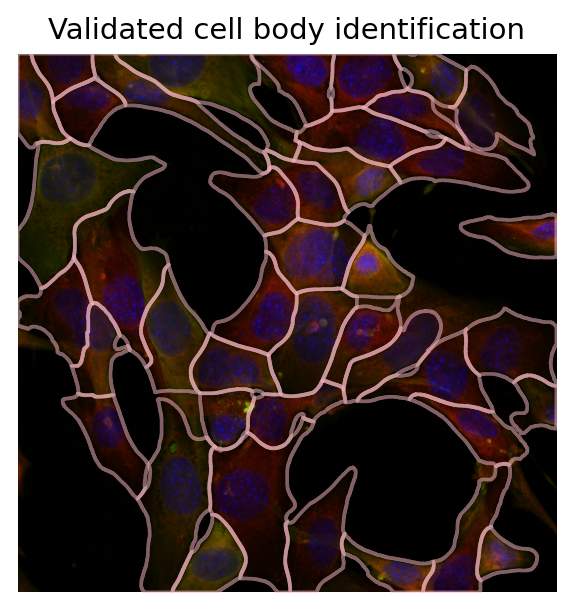

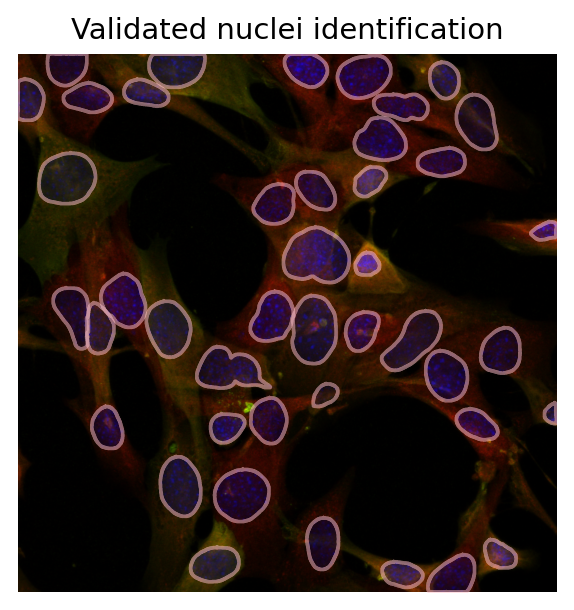

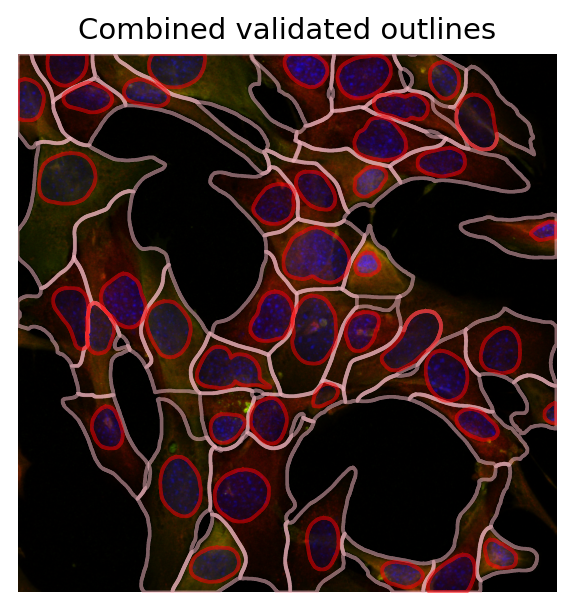

In [ ]:
merge_cells=False,                       # Whether to merge cells if they share a nucleus - "False" will mean both cells get removed
merge_nuclei=True                       # Merge multiple nuclei within a single cell body - "False" will mean both nuclei and cell body will be removed
remove_edge_cells=False                  # Remove cell bodies that touch the the edge of the image

'''Validate the cell bodies and nuclei'''
cellbodies=np.max(cellmasks)
nuclei=np.max(nucleimasks)
print(f"{cellbodies} cell bodies found")
print(f"{nuclei} nuclei found")

'''Identify neurons that do not contain at least 50% of a nucleus'''
nuclei_mask_with_neuron_id=np.zeros((img[0].shape[0], img[0].shape[1]))
false_cell_bodies=[]
overlap_list_list=[]    # List of overlap lists
couple_list=[]
multiple_nuclei_cells=0

# Remove cell bodies that toch the edge of the image
if remove_edge_cells:
    removed_edge_cells=0
    # Collect all values on the border
    edges = np.concatenate([
        cellmasks[0, :],           # Top edge
        cellmasks[-1, :],          # Bottom edge
        cellmasks[:, 0],        # Left edge (excluding corners)
        cellmasks[:, -1]        # Right edge (excluding corners)
    ])
    edge_cells=np.unique(edges)
    for cell_body in edge_cells:
        cellmasks[cellmasks==cell_body]=0
        removed_edge_cells+=1
    if removed_edge_cells !=0:
        print(f"Removed {removed_edge_cells} cell bodies that were on the border of the image")

# Loop over all cell bodies
for cell_body in np.unique(cellmasks[cellmasks != 0]):
    overlap_list=[]
    # Create a temporary mask for the cell body
    cell_body_mask=cellmasks==cell_body
    # Loop over all nuclei
    for nucleus in range(1,nuclei+1):
        # Create a temprorary mask for the nuclei
        nucleus_mask=nucleimasks==nucleus
        # Calculate the size of the nucleus
        nucleus_size=np.sum(nucleus_mask)
        # Calculate the % overlap with the cell body
        combinedmask=np.logical_and(cell_body_mask, nucleus_mask)
        overlap=np.sum(combinedmask)/nucleus_size
        overlap_list.append(overlap)
    overlap_list_list.append(overlap_list)

    # Assign nuclei to the cell bodies
    if not np.max(overlap_list)>0.5:
        # print("Cell body without nucleus detected")
        false_cell_bodies.append(cell_body)
    else:
        # Assign all nuclei with >50% overlap to the cell body
        # At the same time, this will remove any nuclei that do not have sufficient overlap with a cell body
        nucleus_indexes = [i for i, value in enumerate(overlap_list) if value > 0.5]

        if len(nucleus_indexes)==1 or merge_nuclei==True:
            for i in nucleus_indexes:
                temp_mask=nucleimasks==i+1
                nuclei_mask_with_neuron_id[temp_mask]=cell_body
                # Remember which nuclei is coupled with which
                couple_list.append([cell_body, i])
        else:
            # Remove the cell body
            cellmasks[cellmasks==cell_body]=0
            multiple_nuclei_cells+=1


print(f"{len(false_cell_bodies)} cell bodies detected without a nucleus")
if multiple_nuclei_cells!=0:
    print(f"{multiple_nuclei_cells} cell bodies removed with more than one nucleus")

'''Merge or remove false cell bodies'''
merged_bodies=0
deleted_bodies=0
deleted_nuclei=0

for false_cell in np.unique(false_cell_bodies):
    # First, check if we can merge the false cell body with another cell body they share a nucleus with
    # Retrieve the overlap list
    # overlap_list=overlap_list_list[false_cell-1]
    # max_overlap=np.argmax(overlap_list)
    cell_body_mask=cellmasks==false_cell
    # Loop over all nuclei
    for nucleus in np.unique(nuclei_mask_with_neuron_id[nuclei_mask_with_neuron_id != 0]):
        # Create a temprorary mask for the nuclei
        nucleus_mask=nucleimasks==nucleus
        # Calculate the size of the nucleus
        nucleus_size=np.sum(nucleus_mask)
        # Calculate the % overlap with the cell body
        combinedmask=np.logical_and(cell_body_mask, nucleus_mask)
        overlap=np.sum(combinedmask)/nucleus_size
        overlap_list.append(overlap)
    max_overlap=np.argmax(overlap_list)

    # Check if it had any overlap with a nucleus that is already coupled to a neuron, and if the user wants to merge cells that share a nucleus
    if (not(np.max(overlap_list)==0)) and (merge_cells):
        could_merge=False
        # Look up which cell body is linked to this nucleus, this is the cell body with the largest overlap
        for item in couple_list:
            if item[1]==max_overlap:
                # Merge the cell bodies
                cellmasks[cellmasks==false_cell]=item[0]
                could_merge=True
        # If we could not merge, also remove the false cell body
        if not could_merge:
            # Remove false cell bodies
            mask=cellmasks==false_cell
            cellmasks[mask]=0
            deleted_bodies+=1
        else: 
            merged_bodies+=1

    # If the user does not want to merge, or there is no potential cell to merge with
    else:
        # Remove false cell bodies
        mask=cellmasks==false_cell
        cellmasks[mask]=0
        deleted_bodies+=1

        # Additionally, if the user did not want to merge, also remove the nuclei and cell body connected to the false cell body
        if not merge_cells: #and not np.max(overlap_list)==0:
            # Remove associated nuclei and cell body
            # First, identify the nuclei this cell body was associated with, which is the nucleus it shares the largest overlap with
            # This has been calculated earlier, and is the variable max_overlap
            # Look up which cell body is linked to this nucleus
            for item in couple_list:
                if item[1]==max_overlap:
                    # Remove the associated cell body
                    cellmasks[cellmasks==item[0]]=0
                    deleted_bodies+=1
                    # Remove the associated nucleus
                    nuclei_mask_with_neuron_id[nuclei_mask_with_neuron_id==item[0]]=0
                    deleted_nuclei+=1
    
    
print(f"{merged_bodies} cell bodies merged, {deleted_bodies} cell bodies removed")
if deleted_nuclei != 0:
    print(f"Detected multiple cells sharing a nuclei, resulting in {deleted_nuclei} deleted nuclei and the removal of overlapping cell bodies")


'''Allign cell bodies and nuclei'''
# It might be possible that not all of the pixels of a nucleus, are entirely within the linked cell body
# This is fixed by making sure all pixels of the nucleus are also correctly labeled on the cellmask
# Loop over all nuclei
for nucleus in np.unique(nuclei_mask_with_neuron_id[nuclei_mask_with_neuron_id != 0]):
    temp_mask=nuclei_mask_with_neuron_id==nucleus
    cellmasks[temp_mask]=nucleus

'''Display the validation results'''
nuclei_mask_with_neuron_id=nuclei_mask_with_neuron_id.astype(int)
cmap='twilight'
cmap2='hot'
ALPHA=0.75

colour_values=np.random.rand(np.max(cellmasks)+1)

print(f"{len(np.unique(cellmasks))-1} cell bodies validated")
print(f"{len(np.unique(nuclei_mask_with_neuron_id))-1} nuclei validated")

plot_cellmasks=np.zeros(cellmasks.shape)
for value in np.unique(cellmasks):
    if value !=0:
        plot_cellmasks[cellmasks==value]=colour_values[value]
plt.imshow(img[0], cmap=cmap2)
plt.imshow(plot_cellmasks, cmap=cmap, alpha=((cellmasks!=0).astype(float))*ALPHA)
for cell_body in np.unique(cellmasks[cellmasks != 0]):
    center=center_of_mass(cellmasks==cell_body)
    plt.text(center[1], center[0], str(cell_body), color='white', ha='center', va='center', fontsize=12)
plt.axis('off')
plt.savefig(f"{directory}/validated_cell_masks.png", dpi=dpi)
plt.show()
plt.close()

plot_nuclei=np.zeros(nuclei_mask_with_neuron_id.shape)
for value in np.unique(nuclei_mask_with_neuron_id):
    if value !=0:
        plot_nuclei[nuclei_mask_with_neuron_id==value]=colour_values[value]
plt.imshow(img[0], cmap=cmap2)
plt.imshow(plot_nuclei, cmap=cmap, alpha=((nuclei_mask_with_neuron_id!=0).astype(float))*ALPHA)
for nucleus in np.unique(nuclei_mask_with_neuron_id[nuclei_mask_with_neuron_id != 0]):
    center=center_of_mass(nuclei_mask_with_neuron_id==nucleus)
    plt.text(center[1], center[0], str(nucleus), color='white', ha='center', va='center', fontsize=12)
plt.axis('off')
plt.savefig(f"{directory}/validated_nuclei_masks.png", dpi=dpi)
plt.show()
plt.close()

# print(np.unique(cellmasks))
# print(np.unique(nuclei_mask_with_neuron_id))

plot_outlines(cellmasks, img, 'Validated cell body identification', directory=directory)
plot_outlines(nuclei_mask_with_neuron_id, img, 'Validated nuclei identification', directory=directory)

plot_both_outlines(cellmasks, nuclei_mask_with_neuron_id, img, 'Combined validated outlines', directory)

✅ Key Improvements Applied
	1.	✅ Modularize key steps: segment, validate, and visualize become clear blocks.
	2.	✅ Robust I/O: validate channel inputs and TIFF loading.
	3.	✅ Add sanity checks and documentation.
	4.	✅ Optimize numpy operations (e.g., vectorization where appropriate).
	5.	✅ Clarify intent with renamed variables and inline comments.

In [10]:
def load_multichannel_stack(source_path):
    img = imread(source_path)  # shape: (C, H, W)
    assert img.ndim == 3, "Expected shape (channels, height, width)"
    img = img.astype(np.float32)
    img /= np.max(img, axis=(1, 2), keepdims=True)
    return img

In [11]:
from cellpose import models

def run_cellpose_segmentation(img, diameter, channels, flow_threshold, cellprob_threshold, gpu=False):
    model = models.Cellpose(gpu=gpu, model_type='cyto3')
    masks, flows, styles, diams = model.eval(
        img,
        diameter=diameter,
        channels=channels,
        flow_threshold=flow_threshold,
        cellprob_threshold=cellprob_threshold
    )
    return masks

In [12]:
def validate_and_pair_cells(cellmasks, nucleimasks, merge_cells=False, merge_nuclei=True, remove_edge_cells=False):
    validated_cells = np.copy(cellmasks)
    validated_nuclei = np.zeros_like(cellmasks, dtype=int)

    num_cells = np.max(validated_cells)
    num_nuclei = np.max(nucleimasks)
    false_cells = []
    multiple_nuclei_cells = 0
    couple_list = []

    # Remove edge-touching cells if required
    if remove_edge_cells:
        edge_labels = np.unique(np.concatenate([
            validated_cells[0, :], validated_cells[-1, :],
            validated_cells[:, 0], validated_cells[:, -1]
        ]))
        for label in edge_labels:
            validated_cells[validated_cells == label] = 0

    # Validate pairing
    for cid in range(1, num_cells + 1):
        cell_mask = validated_cells == cid
        overlaps = []

        for nid in range(1, num_nuclei + 1):
            nucleus_mask = nucleimasks == nid
            if np.sum(nucleus_mask) == 0:
                continue
            overlap = np.sum(cell_mask & nucleus_mask) / np.sum(nucleus_mask)
            overlaps.append((nid, overlap))

        valid_nuclei = [nid for nid, ov in overlaps if ov > 0.5]

        if not valid_nuclei:
            false_cells.append(cid)
        elif len(valid_nuclei) > 1 and not merge_nuclei:
            validated_cells[validated_cells == cid] = 0
            multiple_nuclei_cells += 1
        else:
            for nid in valid_nuclei:
                validated_nuclei[nucleimasks == nid] = cid
                couple_list.append((cid, nid))

    return validated_cells, validated_nuclei, false_cells, couple_list

In [13]:
def create_overlay(img, mask, alpha=0.6, cmap='twilight', base_cmap='gray'):
    colored_mask = np.zeros_like(img[0], dtype=np.float32)
    values = np.unique(mask)[1:]
    colors = np.random.rand(np.max(values)+1)

    for v in values:
        colored_mask[mask == v] = colors[v]

    fig, ax = plt.subplots()
    ax.imshow(img[0], cmap=base_cmap)
    ax.imshow(colored_mask, cmap=cmap, alpha=alpha)
    ax.axis('off')
    return fig

In [14]:
def save_fig(fig, filename):
    fig.savefig(filename, bbox_inches='tight', dpi=800)
    plt.close(fig)

In [16]:
from tifffile import imwrite

def export_masks_as_tiff(mask, path):
    imwrite(path, mask.astype(np.uint16))

Aggregates:
G:/Microscopy_Data_Huntingtin_aggregates/stacked_tiff\zstacked_sum_20240131_CKR_E10B_mHtt-HAQ97Doxy96H_BafA4h_HA-star580_CCT1-star635P_A11-star460L_nucspotlive488_2.tif


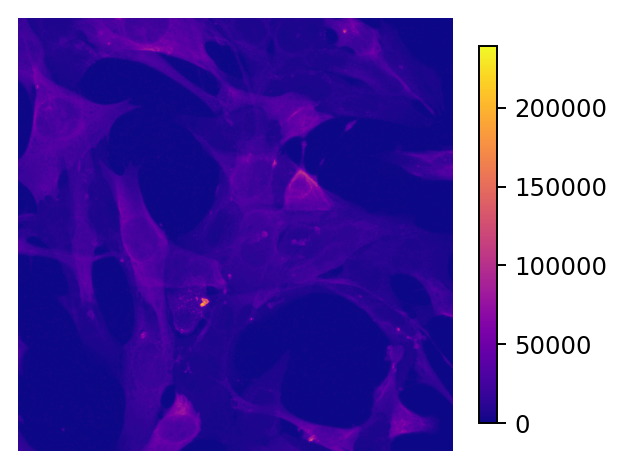

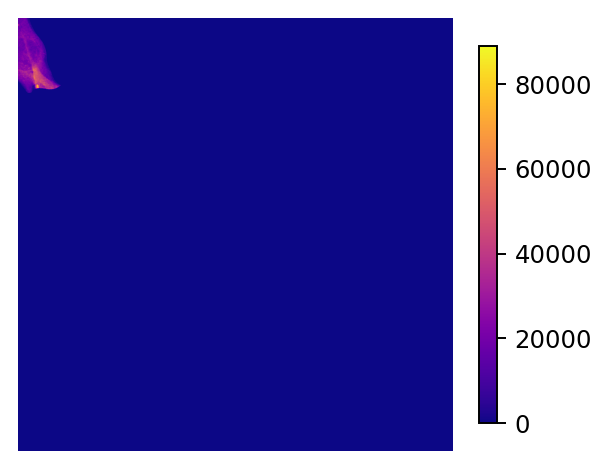

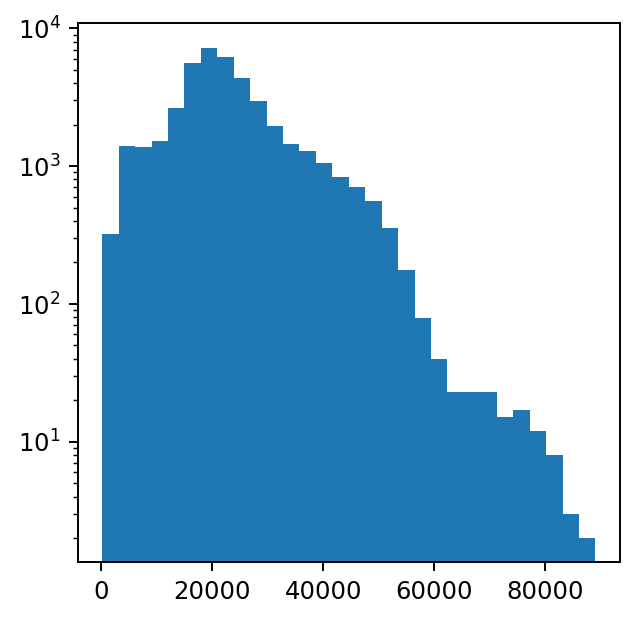

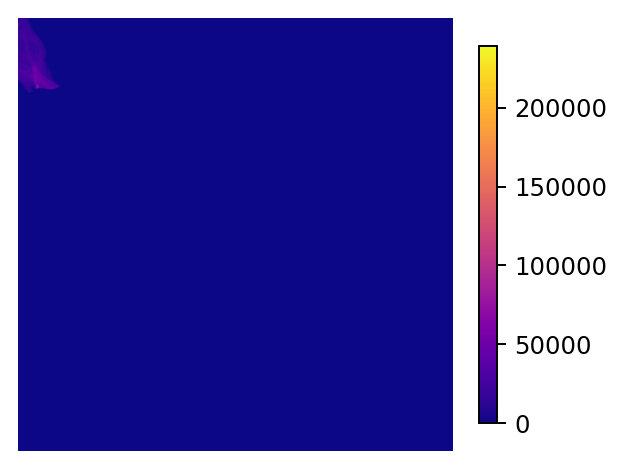

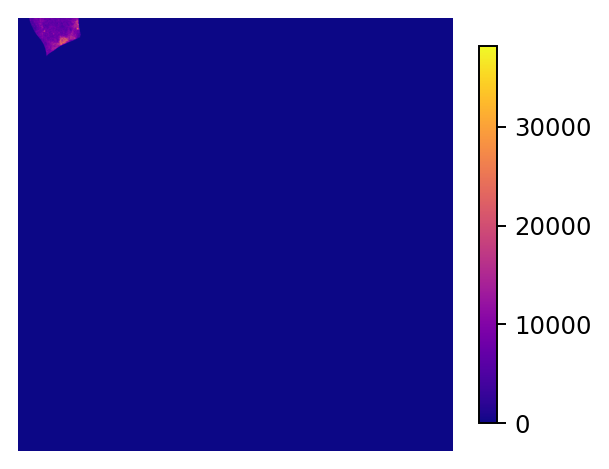

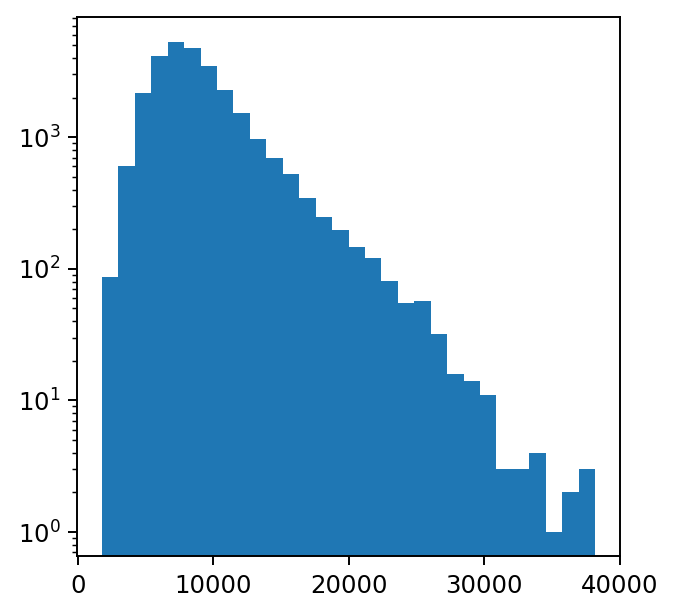

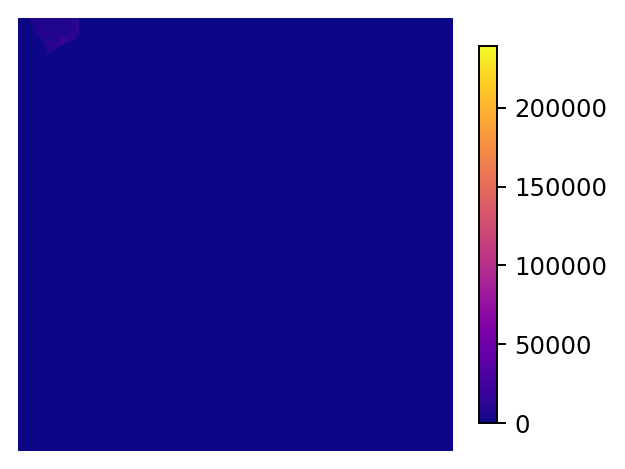

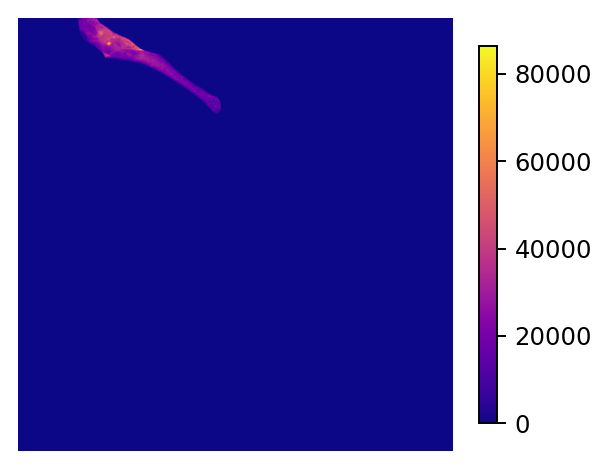

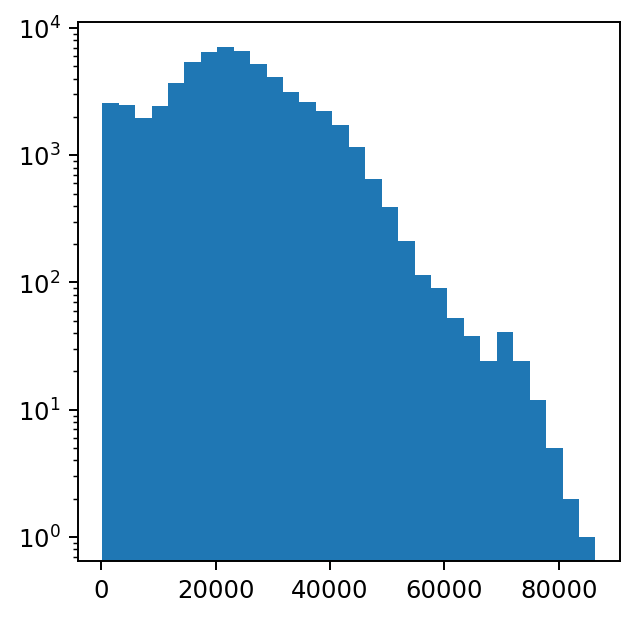

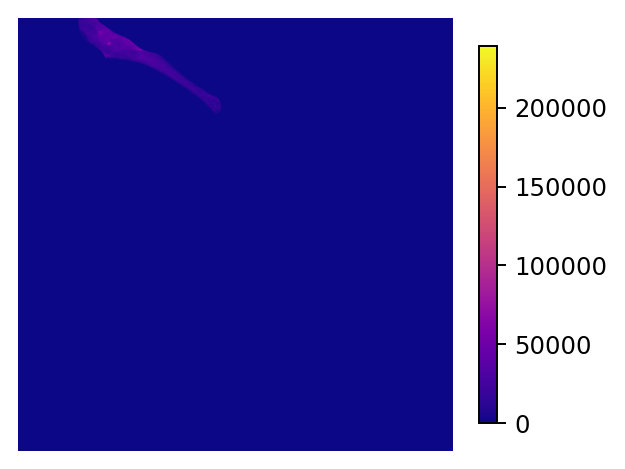

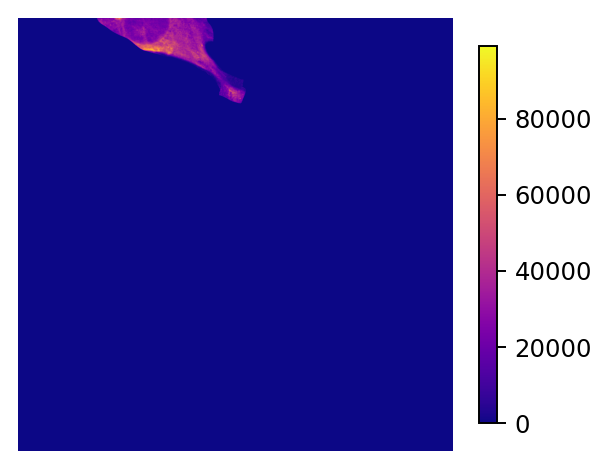

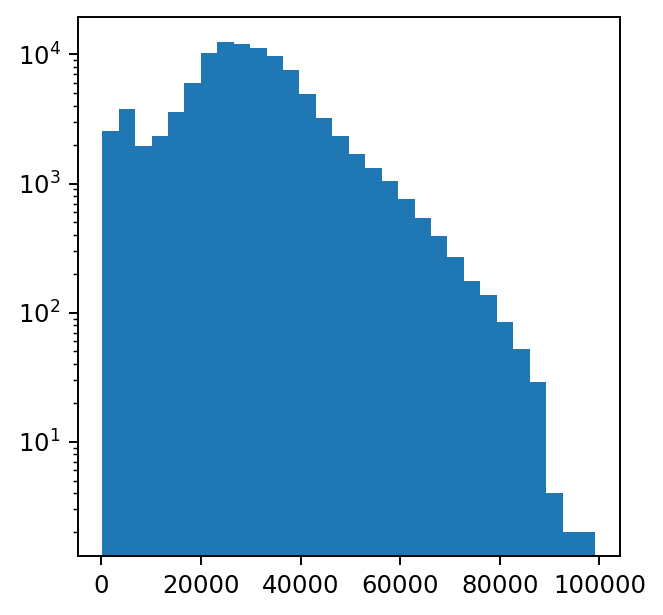

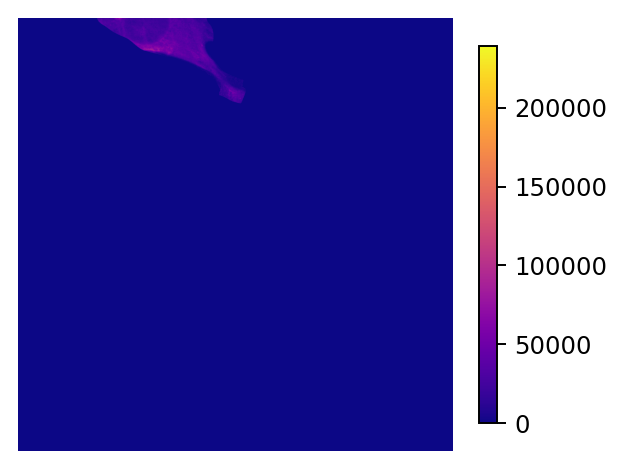

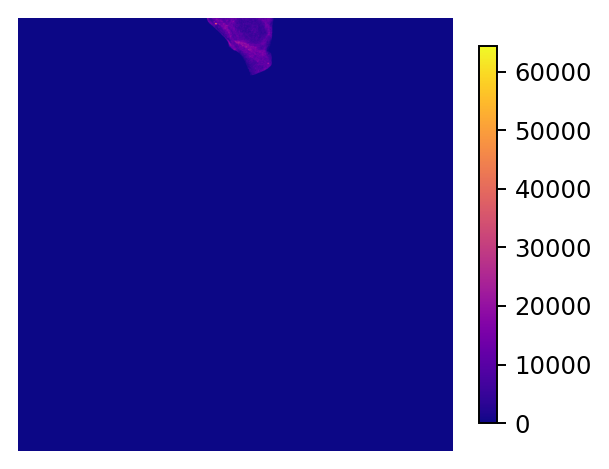

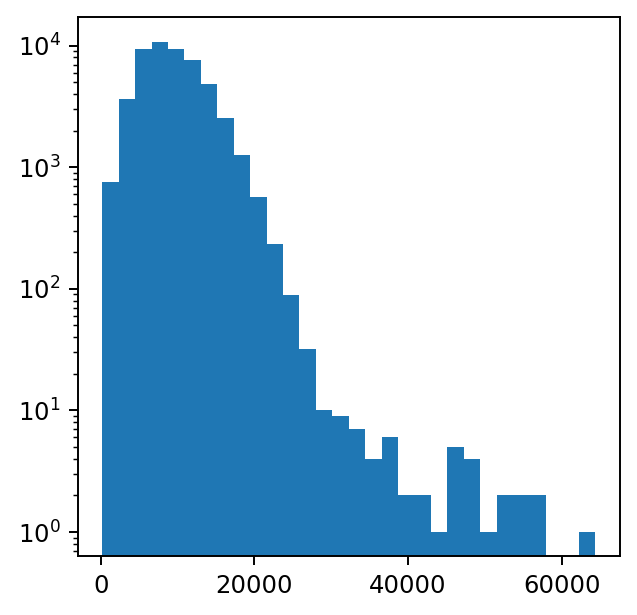

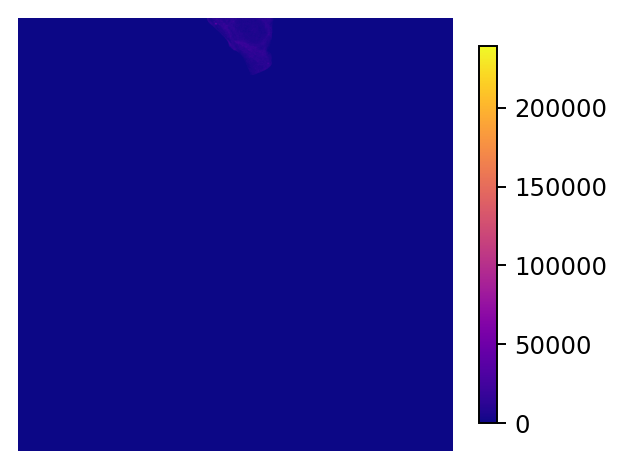

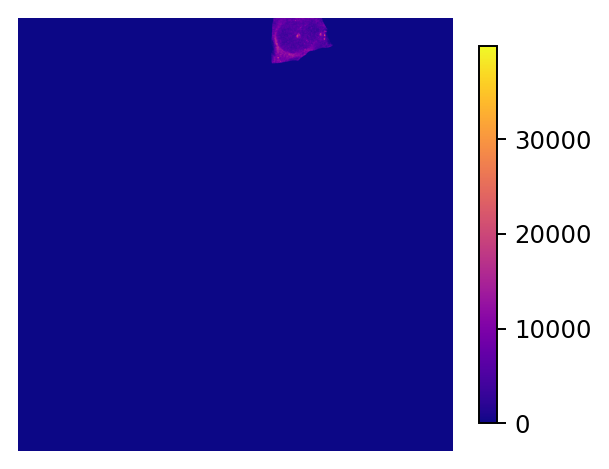

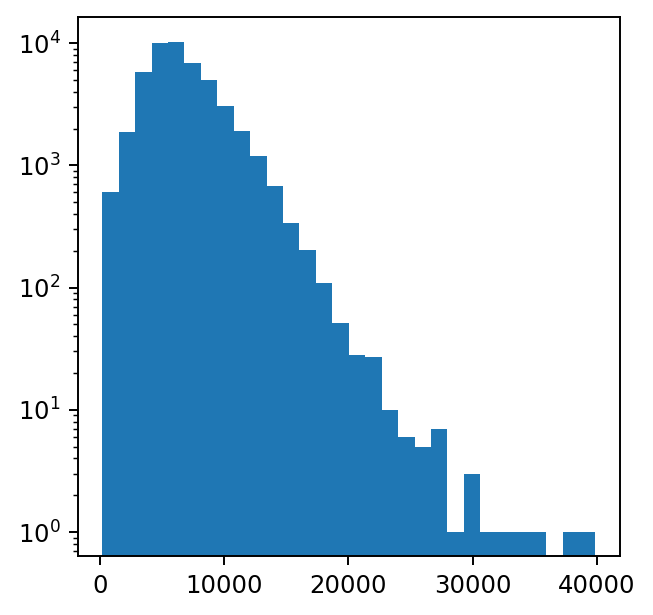

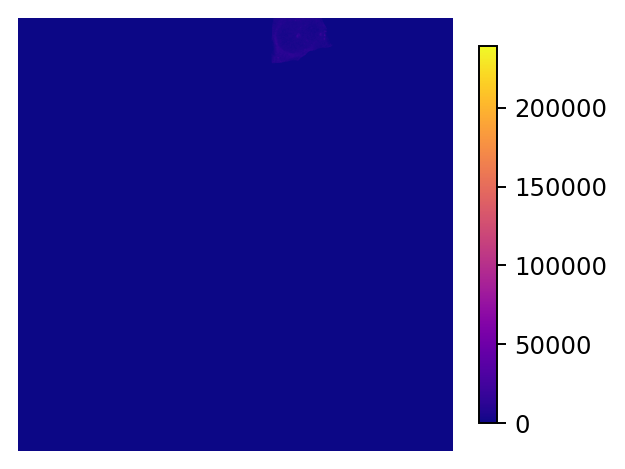

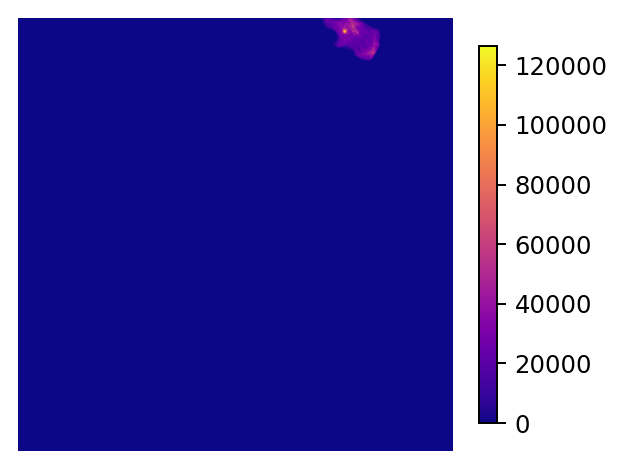

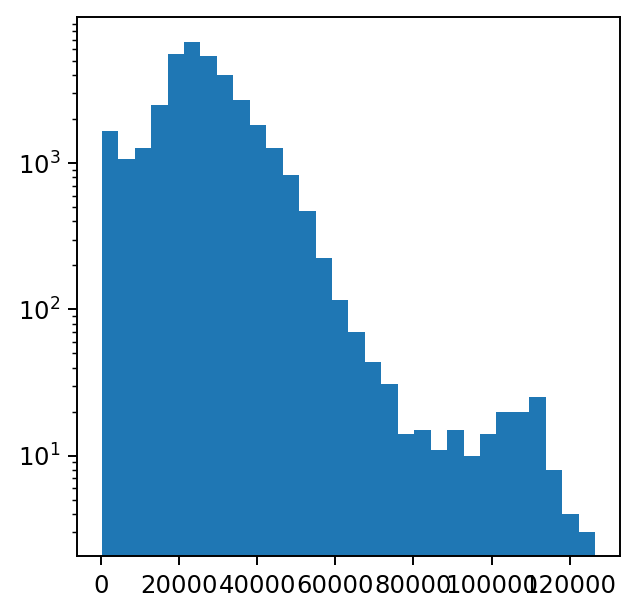

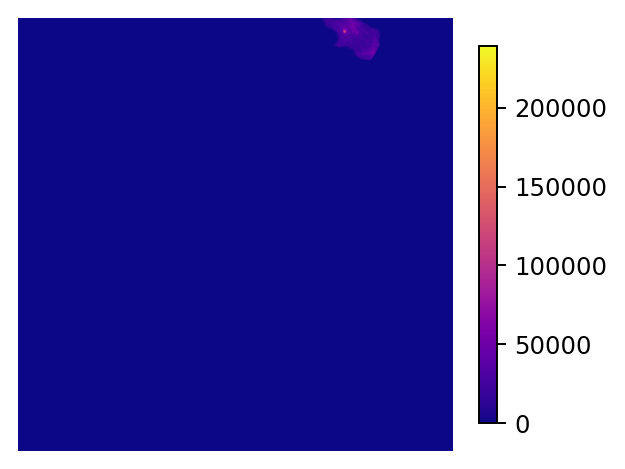

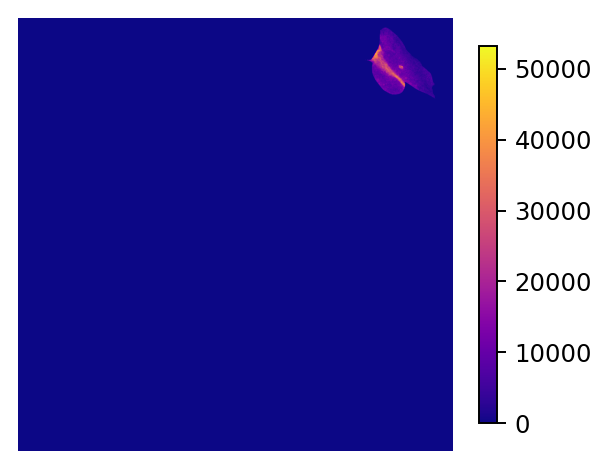

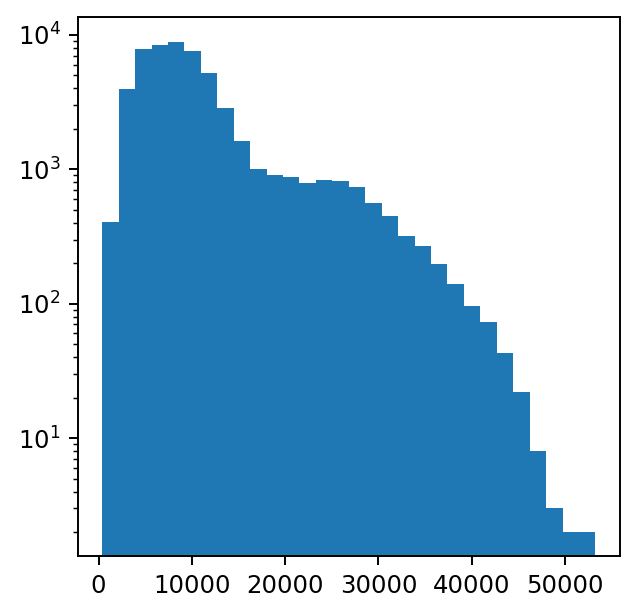

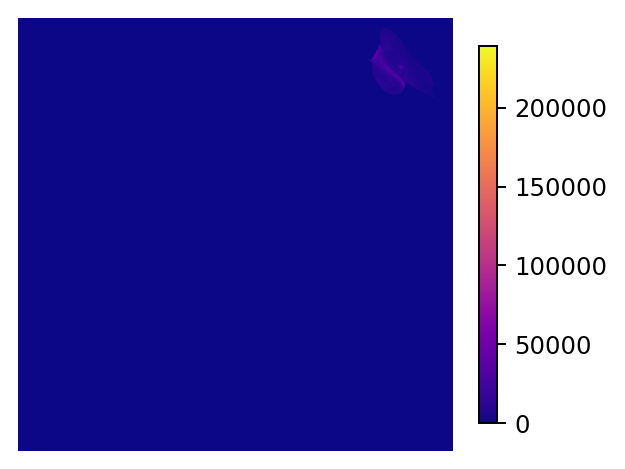

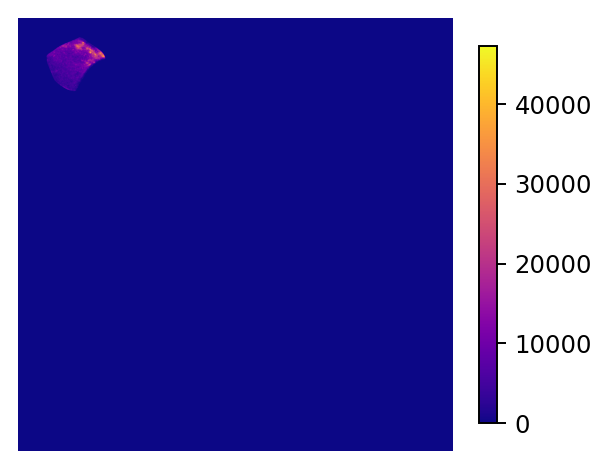

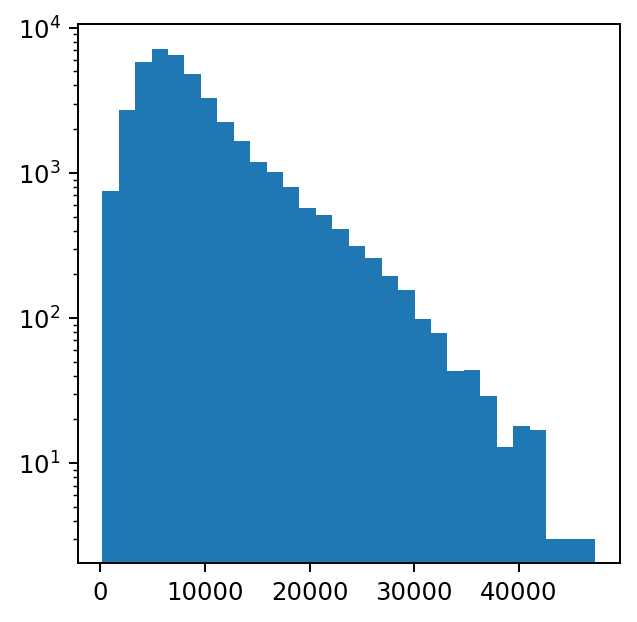

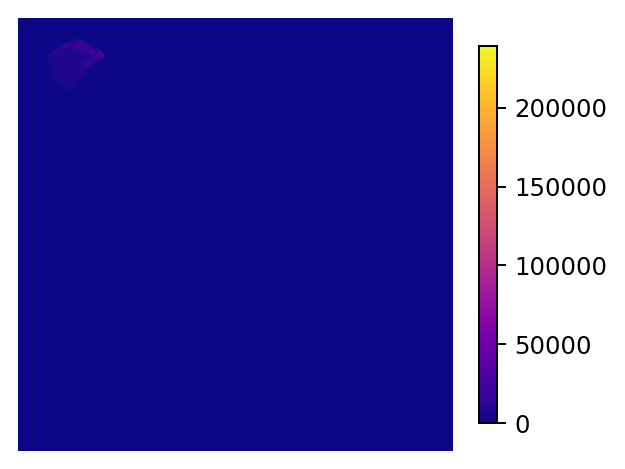

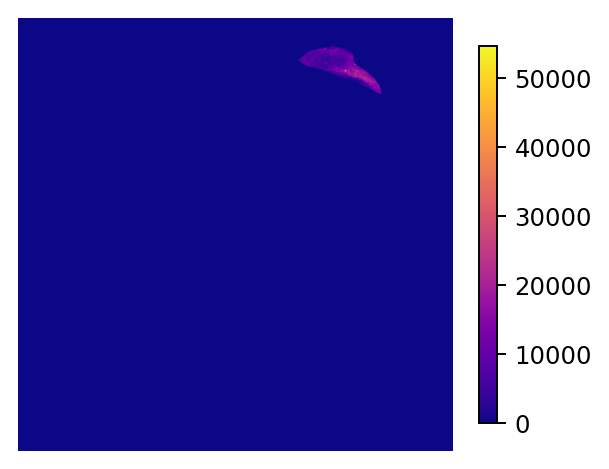

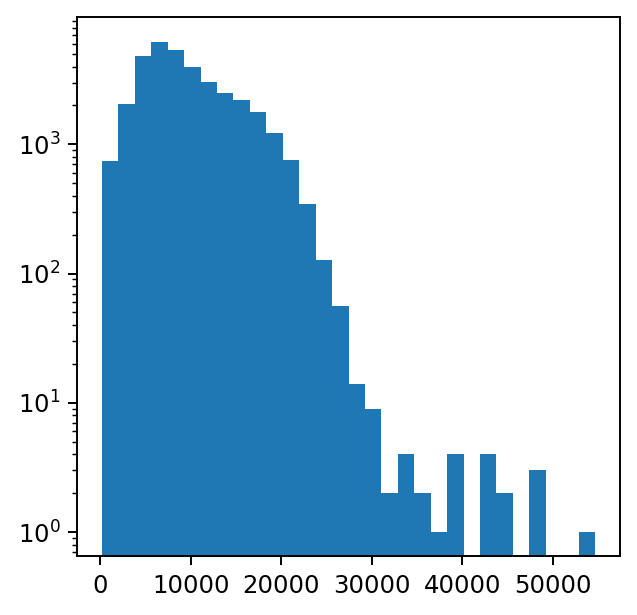

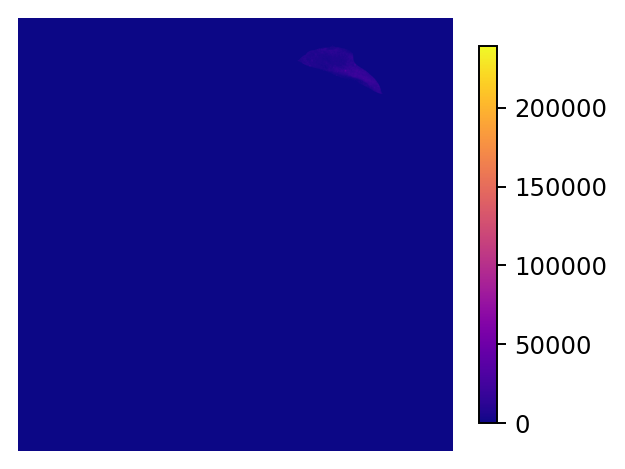

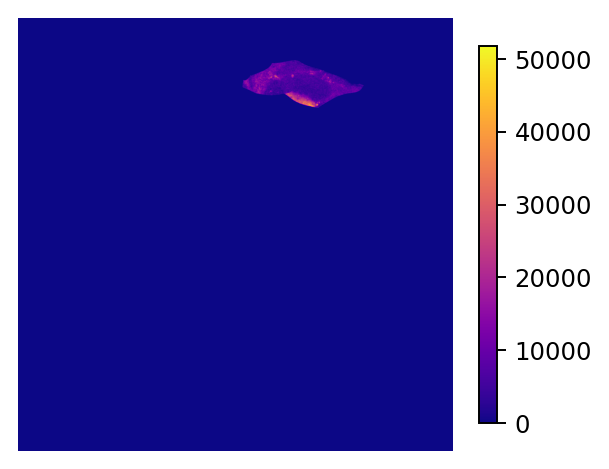

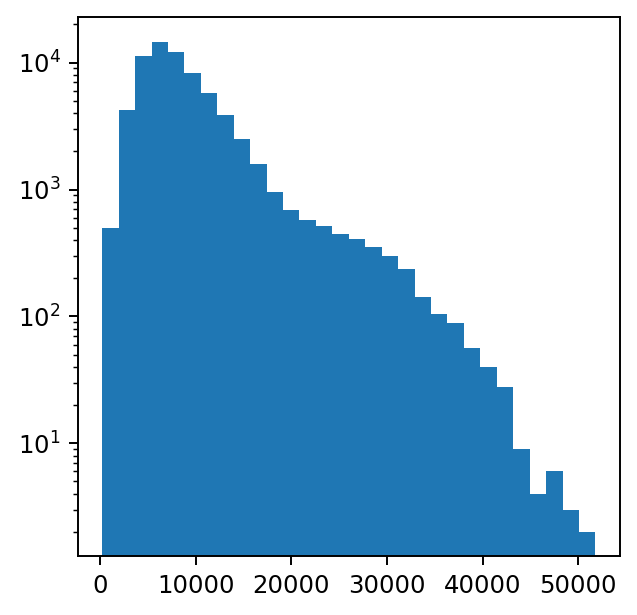

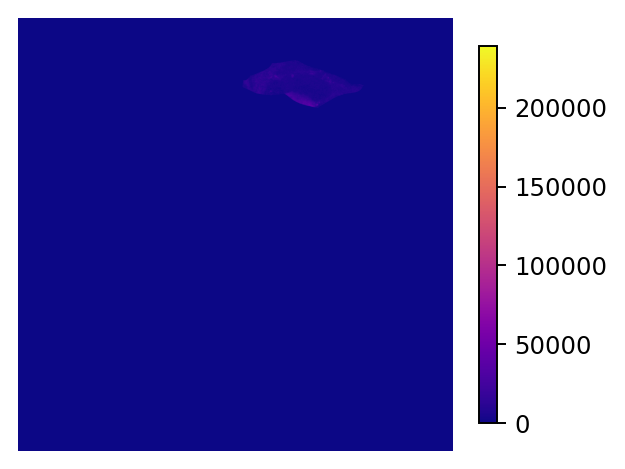

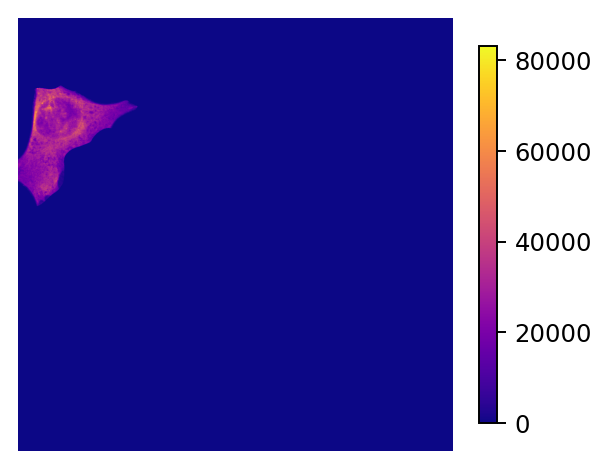

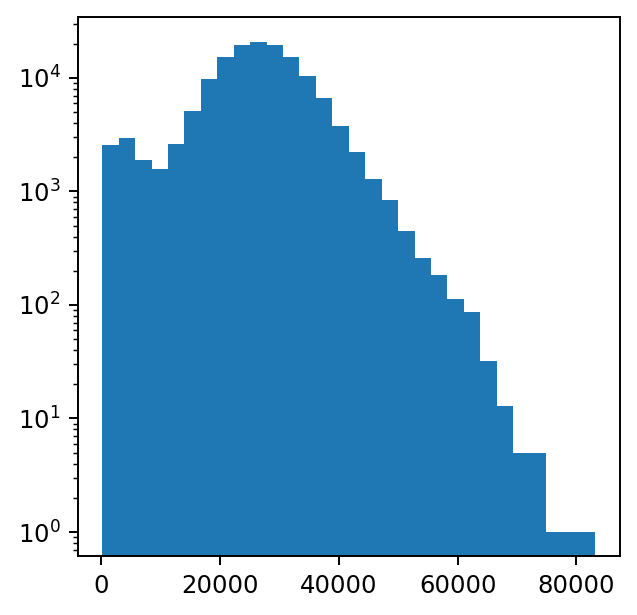

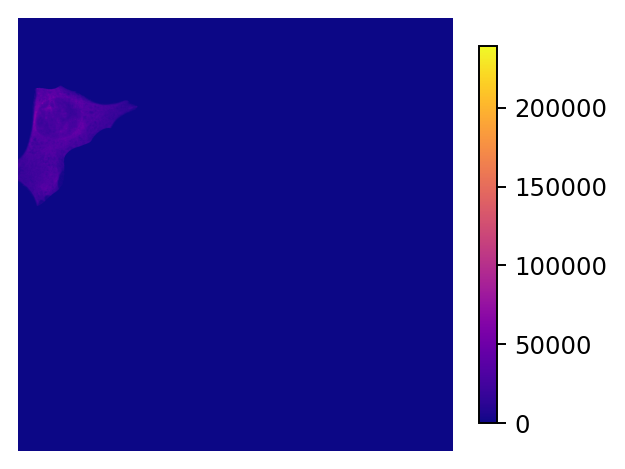

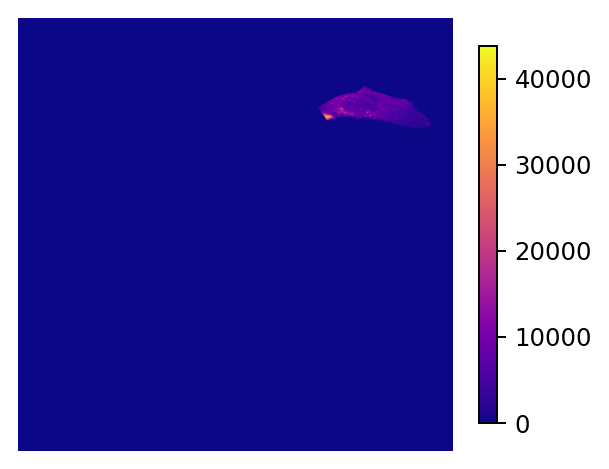

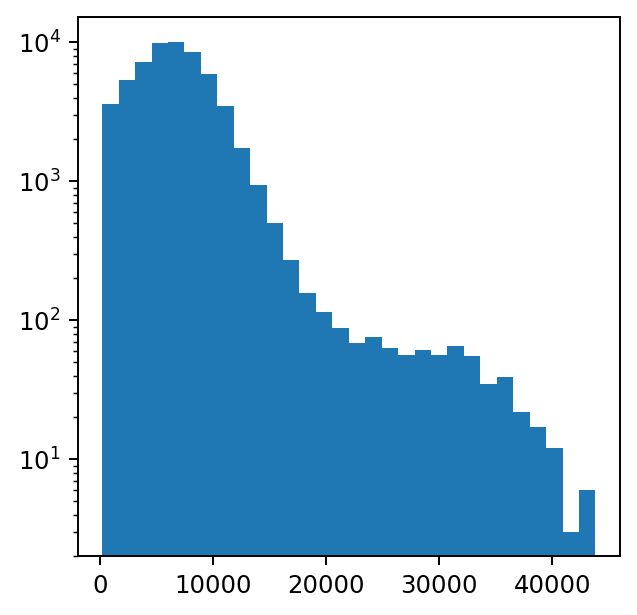

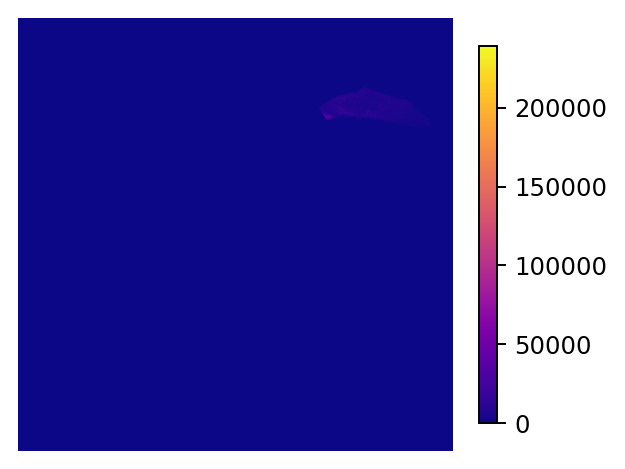

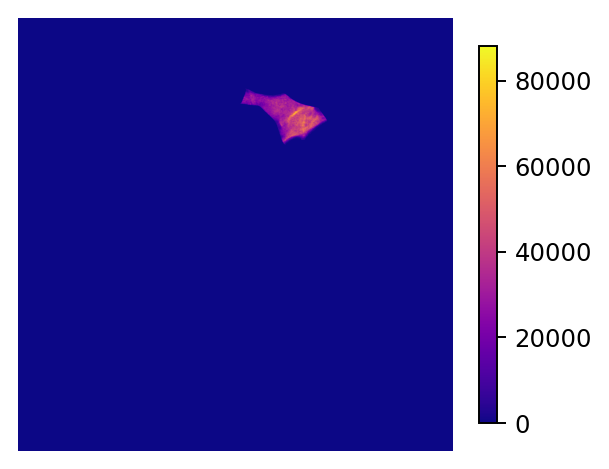

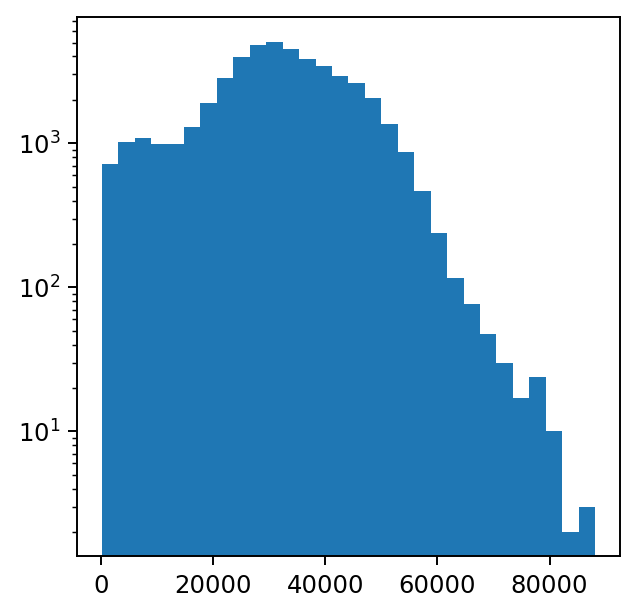

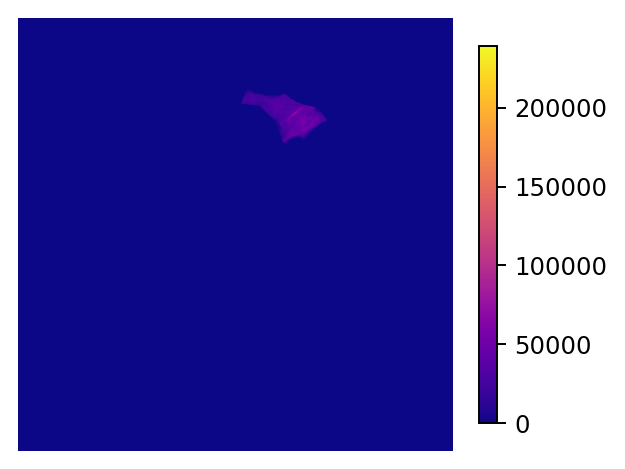

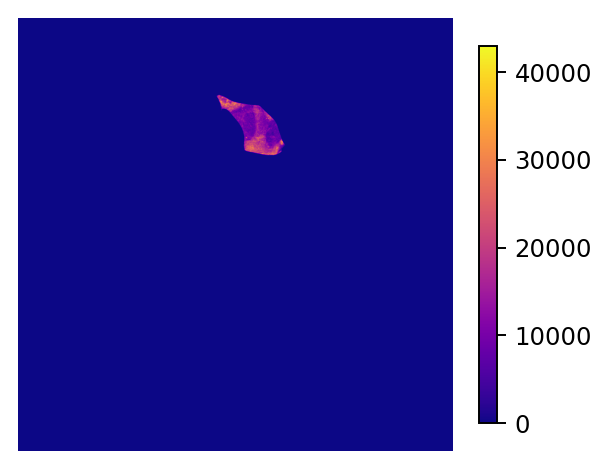

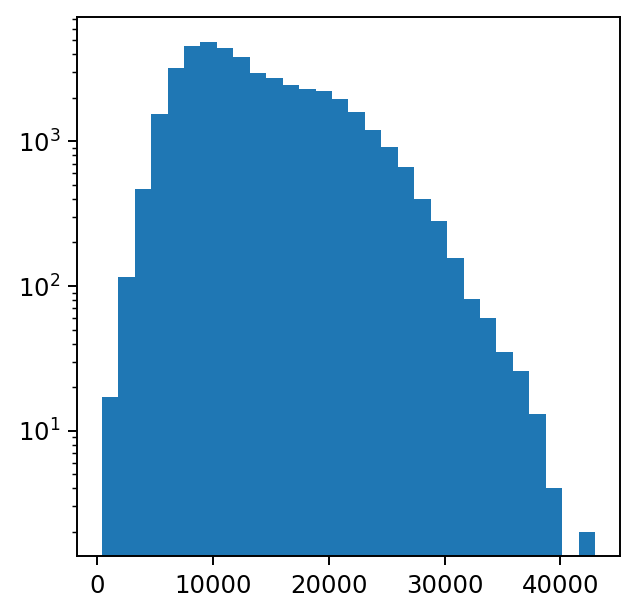

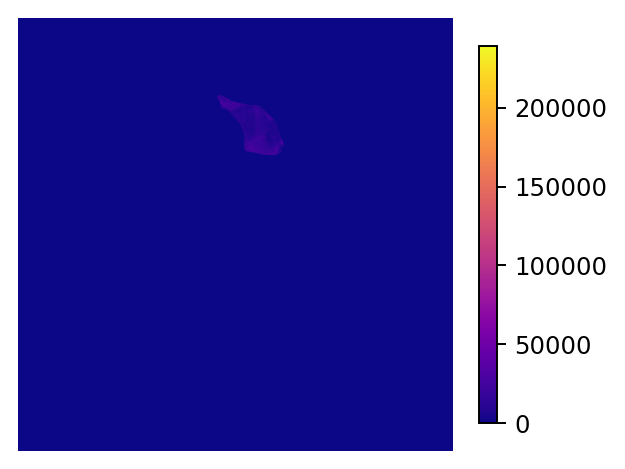

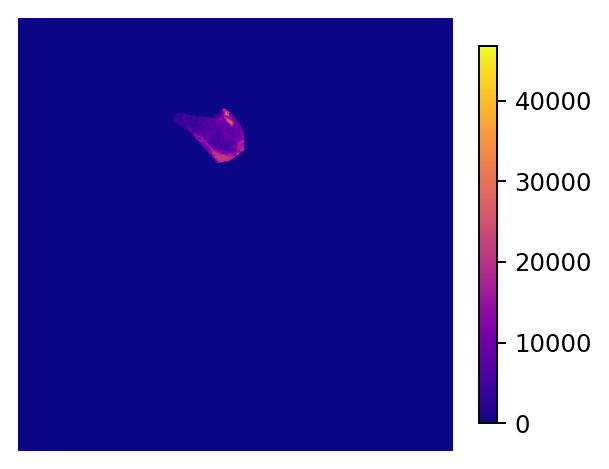

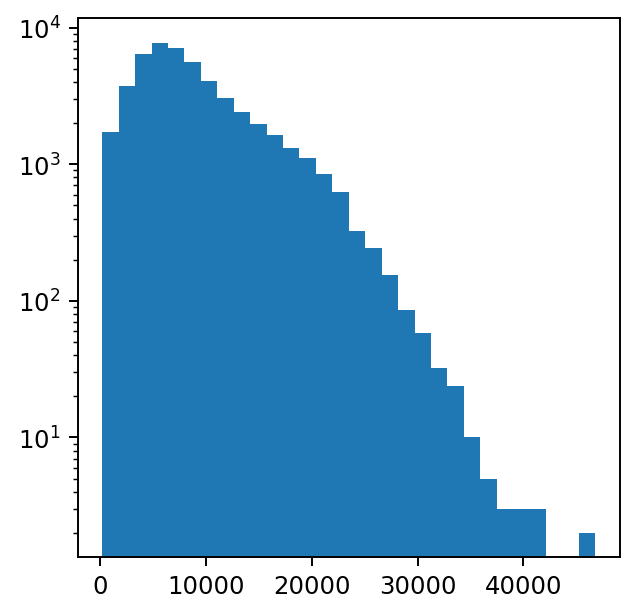

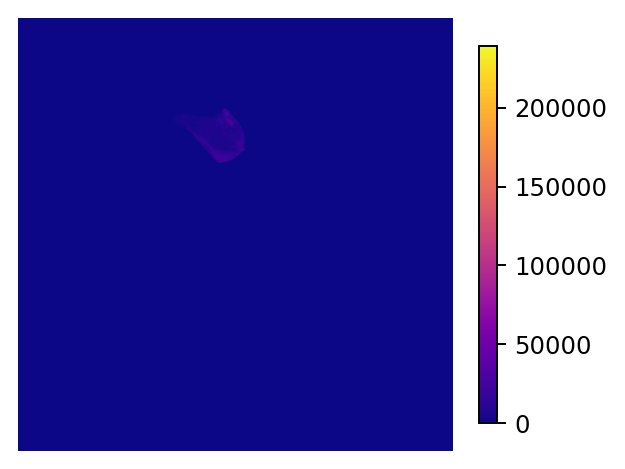

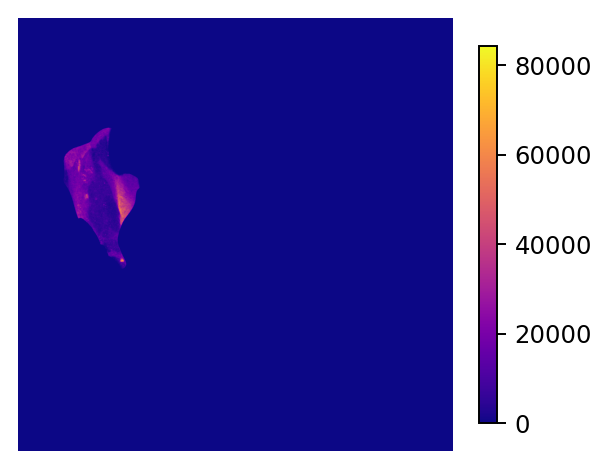

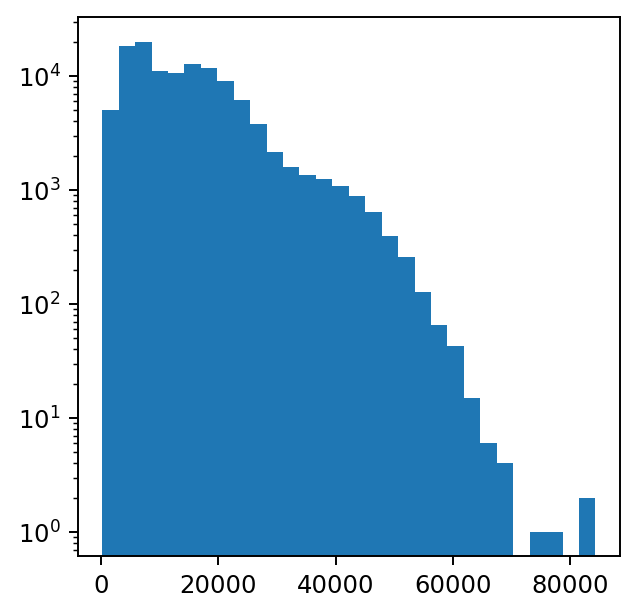

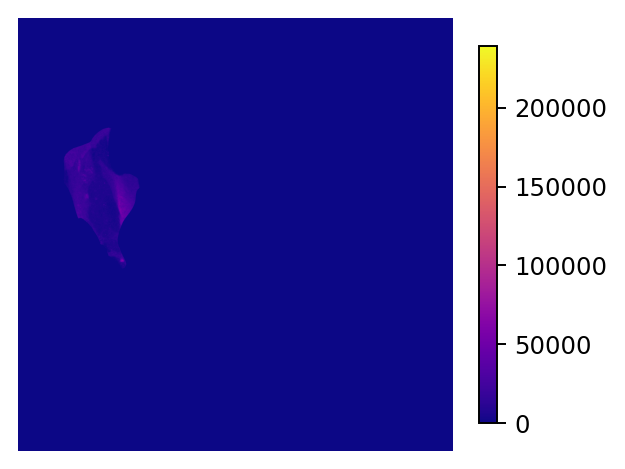

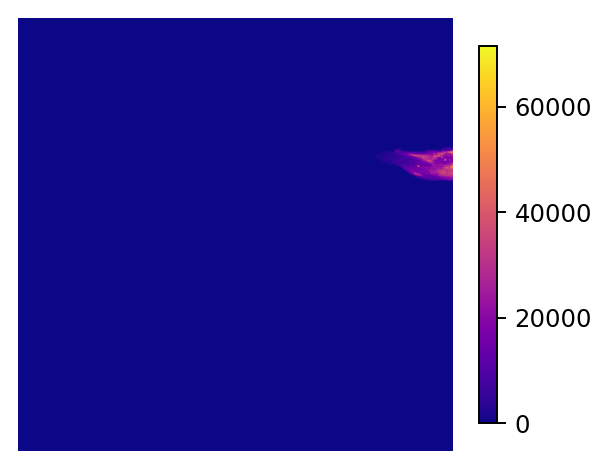

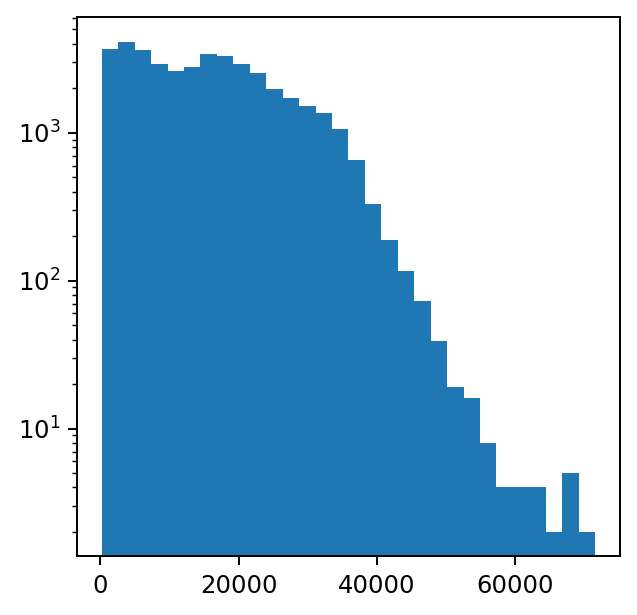

KeyboardInterrupt: 

In [ ]:
'''Display individual neurons'''
import copy
cmap='plasma'
index=1
plt.imshow(img[index], cmap=cmap)
plt.colorbar(shrink=0.7)
plt.axis('off')
plt.show()
plt.close()
for neuron in np.unique(cellmasks[cellmasks != 0]):
    single_neuron=cellmasks!=neuron
    aggregates=copy.deepcopy(img[index])
    aggregates[single_neuron]=0
    plt.imshow(aggregates, cmap=cmap)
    plt.axis('off')
    plt.colorbar(shrink=0.7)
    plt.show()
    plt.close()

    flatlist=aggregates.flatten()
    plt.hist(flatlist[flatlist>0], bins=30)
    plt.yscale("log")
    plt.show()
    plt.close()

    aggregates[0,0]=np.max(img[index])
    plt.imshow(aggregates, cmap=cmap)
    plt.axis('off')
    plt.colorbar(shrink=0.7)
    plt.show()
    plt.close()